In [21]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import scipy.integrate as integr

In [22]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as w
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl
import RungeKutta as rk

In [23]:
path = os.getcwd()

In [33]:
Par = [0.8/1.42953, 8.6*2/4, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [25]:
def fullplot(q):
    q = np.transpose(q, (1,0,2,3))
    print(q[0][q[0] < 0].shape, q[0].shape)
    Nz, Ny =  q[0,0].shape
    Ny_s = int(np.sqrt(Nz))
    Nz_s = int(np.sqrt(Ny))

    # Samples a uniform portion of the rays for visualisation
    Sample = q[:, :, 1::21, 1::21]
    print(Sample[0][Sample[0] < 0].shape, Sample[0].shape)
    cl, ind = wg.ray_spread(len(Sample[0,0]), len(Sample[0,0,0]))
    
    # boolean array to check sgn l
    l_cond = Sample[0] > 0
    print(np.any(l_cond == False))
    #print(Sample[0], Sample.shape, l_cond, l_cond.shape)
    # inverse boolean condition
    inv_l_cond = ~l_cond
    # set l postive on the other side and change to cartesian coordinates
    Sample[0][inv_l_cond] = -Sample[0][inv_l_cond]
    q_cart = w.Sph_cart(Sample)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    L = 20
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    for i in range(len(q_cart[0,0])):
        for j in range(len(q_cart[0,0,0])):
            ij = j + len(q_cart[0,0])*i
            cl_i =cl[ind[ij]]
            ax.plot(q_cart[0,:,i,j][l_cond[:,i,j]],
                    q_cart[1,:,i,j][l_cond[:,i,j]],
                    q_cart[2,:,i,j][l_cond[:,i,j]],
                    color = cl_i)
    ax.set_xlim([-L,L])
    ax.set_ylim([-L,L])
    ax.set_zlim([-L,L])
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    for i in range(len(q_cart[0,0])):
        for j in range(len(q_cart[0,0,0])):
            ij = j + len(q_cart[0,0])*i
            cl_i =cl[ind[ij]]
            ax.plot(q_cart[0,:,i,j][inv_l_cond[:,i,j]],
                    q_cart[1,:,i,j][inv_l_cond[:,i,j]],
                    q_cart[2,:,i,j][inv_l_cond[:,i,j]],
                    color = cl_i)
    ax.set_xlim([-L,L])
    ax.set_ylim([-L,L])
    ax.set_zlim([-L,L])
            
    plt.tight_layout()
    plt.show()    
    
    

In [34]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = w.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.01, 5000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[0.5596244919658909, 4.3, 2.8666666666666667] [12.          3.14159265  1.57079633]
809.010370016098


In [35]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [36]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [37]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

(448794272,) (5000, 400, 400)
(1013419,) (5000, 19, 19)
True


<IPython.core.display.Javascript object>


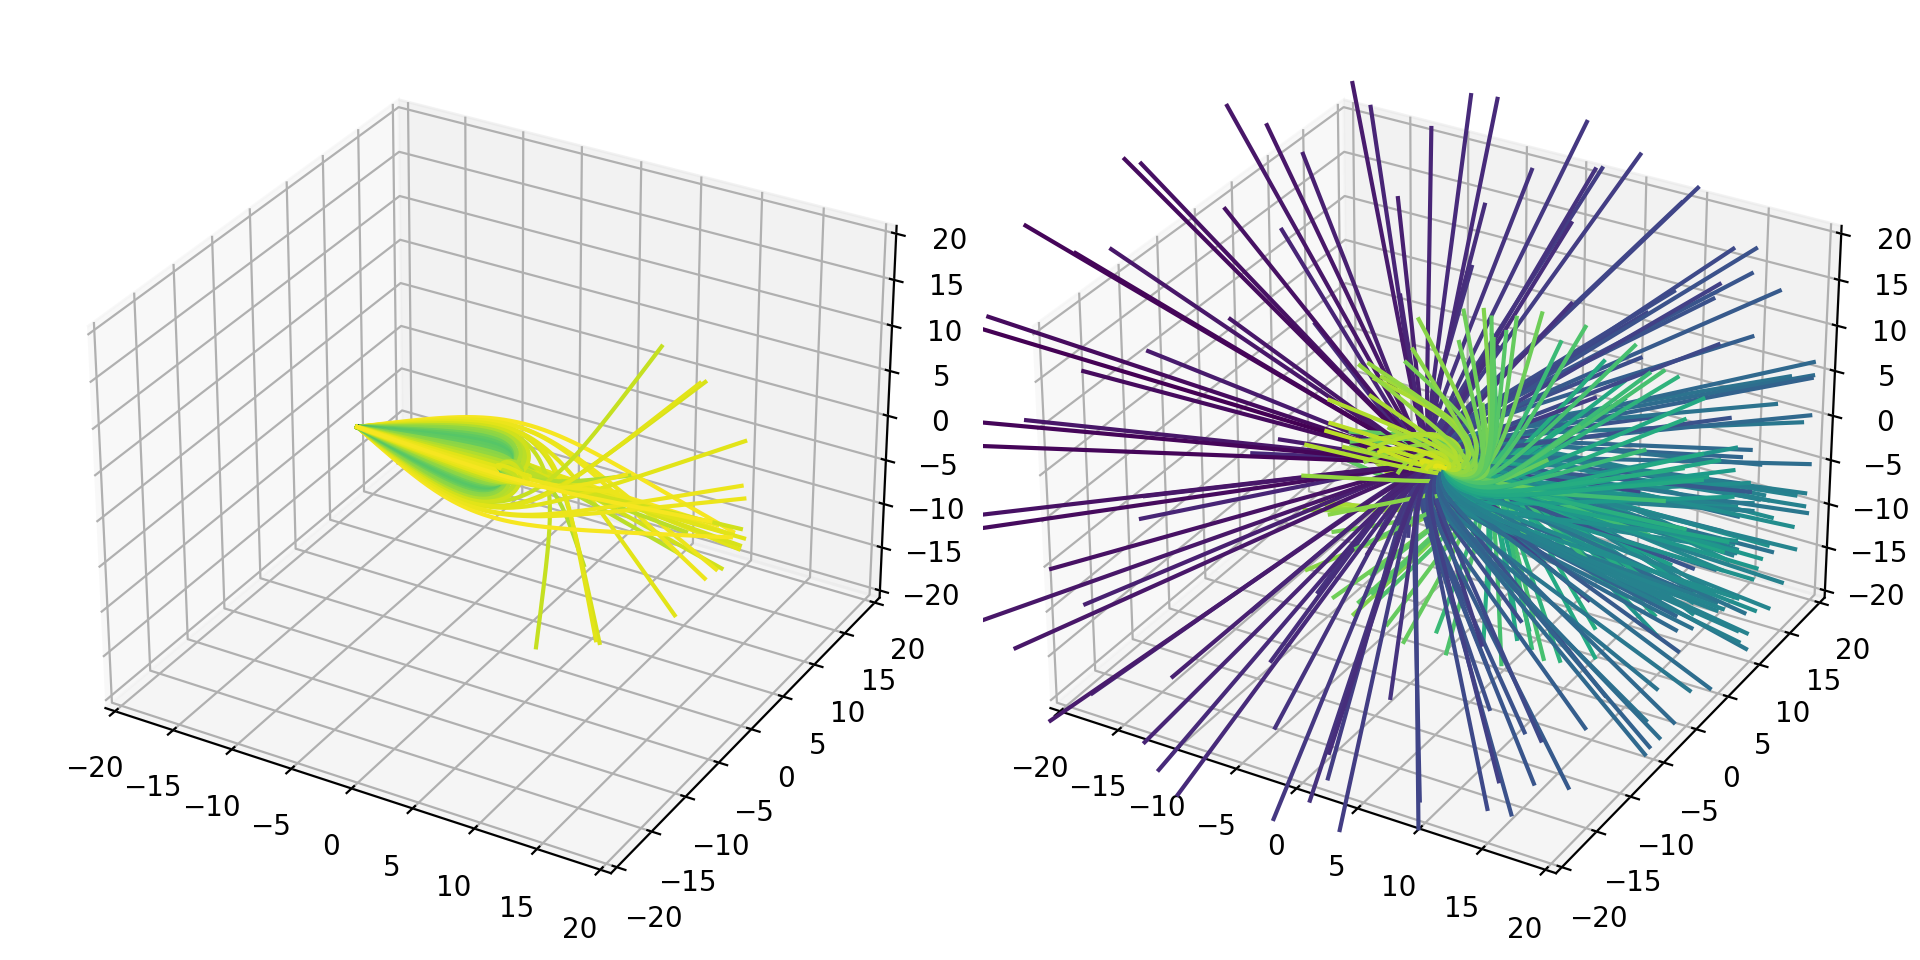

In [38]:
fullplot(Motion1[:, 1])

In [212]:
Motion3, Grid3, CM3  = w.Simulate_DNeg(runge_kutta, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

330.52433729171753


In [213]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg RK4"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion3[-1, 1], np.zeros(Motion3[-1, 1, 0].shape, dtype=bool)))

True

In [226]:
def simulate_raytracer_fullpath(t_end, Par, q0, N, Nz = 14**2, Ny = 14**2, methode = 'BDF'):
    """
    Solves the differential equations using a build in solver (solve_ivp) with
    specified method.
    Input:  - t_end: endtime of the Integration
            - Par: wormhole parameters
            - q0: position of the camera
            - Nz: number of vertical pixels
            - Ny: number of horizontal pixels
            - methode: method used for solving the ivp (standerd runge-kutta of fourth order)

    Output: - Motion: Usual 5D matrix
    """
    print('Initializing screen and calculating initial condition...')

    # end = int(np.ceil(np.sqrt(Ny**2+Nz**2)))
    M, rho, a = Par

    # Reading out values and determining parameters
    S_c = w.screen_cart(Nz, Ny, 1, 1)
    S_cT = np.transpose(S_c, (2,0,1))
    S_sph = w.cart_Sph(S_cT)
    p, Cst = w.inn_momenta(S_c, S_sph, w.Cst_DNeg, w.inn_mom_DNeg, Par)
    p1, p2, p3 = p
    q1, q2, q3 = q0
    Motion = np.empty((Nz,Ny,6,N))

    # Looping over all momenta
    for j in range(0, len(p1)):
        start_it = time.time()
        for i in range(0, len(p1[0])):
            start_it = time.time()
            initial_values = np.array([q1, q2, q3, p1[j][i], p2[j][i], p3[j][i], M, rho, a])
            # Integrates to the solution
            Motion[j,i] = integr.solve_ivp(w.diff_equations, [t_end, 0], initial_values, method = methode, t_eval=np.linspace(t_end, 0, N)).y[:6]

        end_it = time.time()
        duration = end_it - start_it
        print('Iteration ' + str((j, i)) + ' completed in ' + str(duration) + 's.')
    return np.transpose(np.array([Motion[:,:,0:3], Motion[:,:,3:]]), (4,0,3,1,2)) #output same shape as sympl. intgr.

In [32]:
Motion2 = w.simulate_raytracer_fullpath(100, Par, initial_q, 2000, 20**2, 20**2, 'RK45')

NameError: name 'simulate_raytracer_fullpath' is not defined

In [ ]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

In [ ]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], np.zeros(Motion2[-1, 1, 0].shape, dtype=bool)))

In [ ]:
fullplot(Motion2[:, 1])

In [5]:
q_scipy_symm = w.wormhole_with_symmetry2(100, Par, initial_q, 20**2, 20**2)

Initializing screen and calculating initial condition...
[[[0.5       ]
  [0.5       ]
  [0.5       ]
  ...
  [0.5       ]
  [0.5       ]
  [0.5       ]]

 [[0.        ]
  [0.00250627]
  [0.00501253]
  ...
  [0.99498747]
  [0.99749373]
  [1.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
Tijdsduur = 7.157625198364258
Rotating ray...
(3, 400, 1)
(400, 1) (400, 1)
(400, 1)
(3, 400, 400)
Ray rotated!


In [6]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr NewSymm DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(q_scipy_symm, wg.Grid_constr_2D(q_scipy_symm, 11, 1, 0.05)))

True

In [ ]:
M = alpha.size
q_flat = np.empty((3,M))
alpha = alpha.flatten().reshape(M,1)
r_polar = r_polar.flatten().reshape(M,1)
k = np.argmin(np.abs(R.reshape(1, int(Ny/2)) - r_polar), axis=1)
q = np.concatenate(
            np.cos(alpha/2),
            np.sin(alpha/2)*np.tile(Rot_axis,(1,M)), axis=0
            )
for i in range(M):
    q_flat[3, i] = np.dot(rotation_quat(q[i]), q_cart[:,0,k[i]])

In [ ]:
np.array([[0,2],[1,3]]).flatten()

In [72]:
def gdsc(Motion, Par, name, path, geo_label = None, select = None, reduce = False):
    # input: Motion: 5D matrix, the elements being [p, q] with p, q as defined earlier
    #       Par: parameters wormhole
    #       Name: picture/filename
    #       Path: directory
    #       select: Give a list of 2D indices to plot only specific geodesiscs
    #       geo_label: if you're just plotting a list of geodesics (thus its elements in order time, [p,q], coordinate),
    #                   then give here a list of strings that which will be the label of your geodesics, corresponding to the order of your geodesics.
    #       reduce: if true sample geodescics uniformly
    M, rho, a = Par

    if np.any(select == None):
        if np.any(reduce == False):
            Sample = np.transpose(Motion, (1,2,3,0))
        else:
            Motion = np.transpose(Motion, (1,2,0,3,4))
            Ny, Nz =  Motion[0][0][0].shape
            Ny_s = int(np.sqrt(Nz))
            Nz_s = int(np.sqrt(Ny))

            # Samples a uniform portion of the rays for visualisation
            Sample = Motion[:, :, :, 1::Nz_s, 1::Ny_s]
            cl, ind = ray_spread(Nz_s, Ny_s)

    else:
        Motion = np.transpose(Motion, (3,4,0,1,2))
        Sample = np.transpose(
            [Motion[tuple(select[k])] for k in range(len(select))]
            , (2,3,1,0))

    p, q = Sample
    p_l, p_phi, p_th = p
    l, phi, theta = q
    # caluclates coordinates in inbedded space
    ax = plt.figure().add_subplot(projection='3d')
    r = w.dneg_r(l, M, rho, a)
    X, Y = r*np.cos(phi), r*np.sin(phi)
    
    S_l = np.linspace(np.max(l), np.min(l), len(l))
    Col_l = np.concatenate((l.T, np.expand_dims(S_l, axis=0)), axis=0).T
    Col_Z = Dia.imb_f_int(Col_l, Par)
    Z = Col_Z[:,:-1]
    S_Z0 = Col_Z[:,-1] + np.max(Z)

    if np.any(reduce == False):
        for k in range(len(Sample[0,0,0])):
            if np.any(geo_label == None):
                gl = str(select[k])
            else:
                gl = geo_label[k]
            ax.plot(X[:,k], Y[:,k], Z[:,k])
        ax.scatter(X[0,0] , Y[0,0], Z[0,0], label='camera', c = 'r')
        #ax.set_title("Path of a geodesic that lead to noise")
        ax.legend()
    else:
        for i in range(Nz_s):
            for j in range(Ny_s):
                ij = i + Nz_s*j
                cl_i =cl[ind[ij]]
                ax.plot(X[:,i,j], Y[:,i,j], Z[:,i,j], color = cl_i, alpha=0.5)
        ax.scatter(X[0,0,0] , Y[0,0,0], Z[0,0,0], label='camera', c = 'r')
        ax.set_title("Geodesics")
        ax.legend()

    # adds surface

    #S_l = np.linspace(np.max(l), np.min(l), len(l))
    S_phi = np.linspace(0, 2*np.pi, len(l))
    S_R, S_PHI = np.meshgrid(w.dneg_r(S_l, M, rho, a), S_phi) # radius is r(l)

    # tile because symmetric for rotations, undependant on phi
    # Integral for Z direction like defined in the paper
    S_Z = np.tile(S_Z0, (len(l), 1)) #z(l)
    
    S_X, S_Y = S_R*np.cos(S_PHI), S_R*np.sin(S_PHI)
    #print(S_X.shape, S_Y.shape, S_Z.shape)
    ax.plot_surface(S_X, S_Y, S_Z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
    plt.tight_layout()
    # Hide grid lines
    ax.grid(False)

    ax.axis("off")
    #ax.set_zlim([-10,10])
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()

<IPython.core.display.Javascript object>


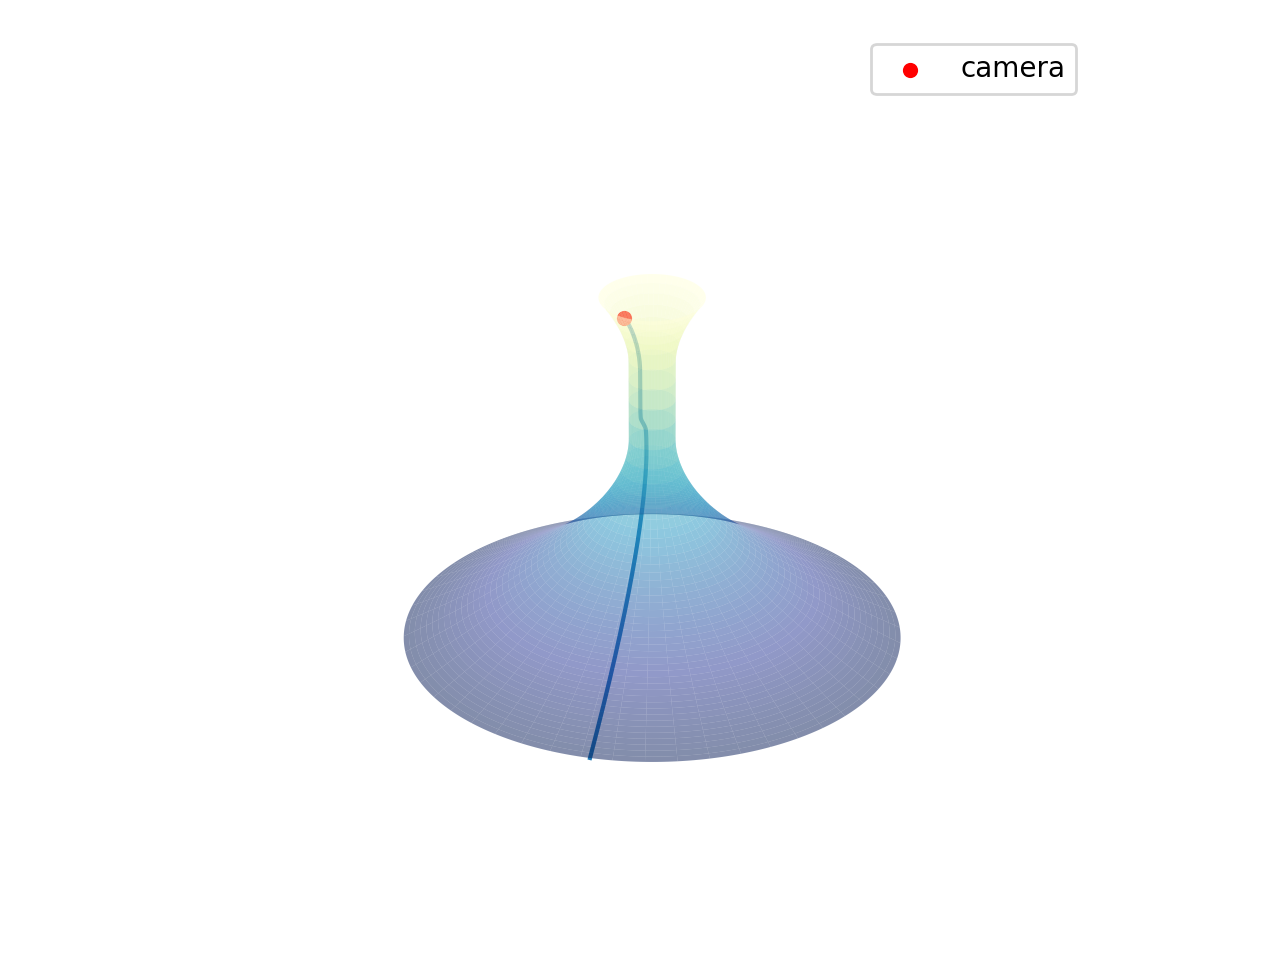

In [74]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
#Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion2, Par, "Pictures/Noise "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [40]:
def plot_CM(CM, Label, name, path):
    #input: 3D array containing energy of each ray over time, advancement in time on first row
    # plot the constants of motion over the partition of the rays

    Ny, Nz =  CM[0,0].shape
    CM = np.transpose(CM, (1,0,2,3))
    N_C = len(CM)
    cl, ind = wg.ray_spread(Nz, Ny)

    fig, ax = plt.subplots(1, N_C)
    x = np.arange(len(CM[0]))
    for k in range(N_C):
        for i in range(Nz):
            for j in range(Ny):
                ij = i + Nz*j
                cl_i =cl[ind[ij]]
                ax[k].plot(x, CM[k,:,i,j], color=cl_i)
        ax[k].set_yscale("log")
        #ax[k].set_title(Label[k] + ",  Donker pixels binnenkant scherm, lichte pixels buitenkant")
        ax[k].set_xlabel("timesteps")
        ax[k].set_ylabel(Label[k])
        ax[k].set_title("sum subdivision rays")
    plt.tight_layout()
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()

In [ ]:
CM2 = np.array([w.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


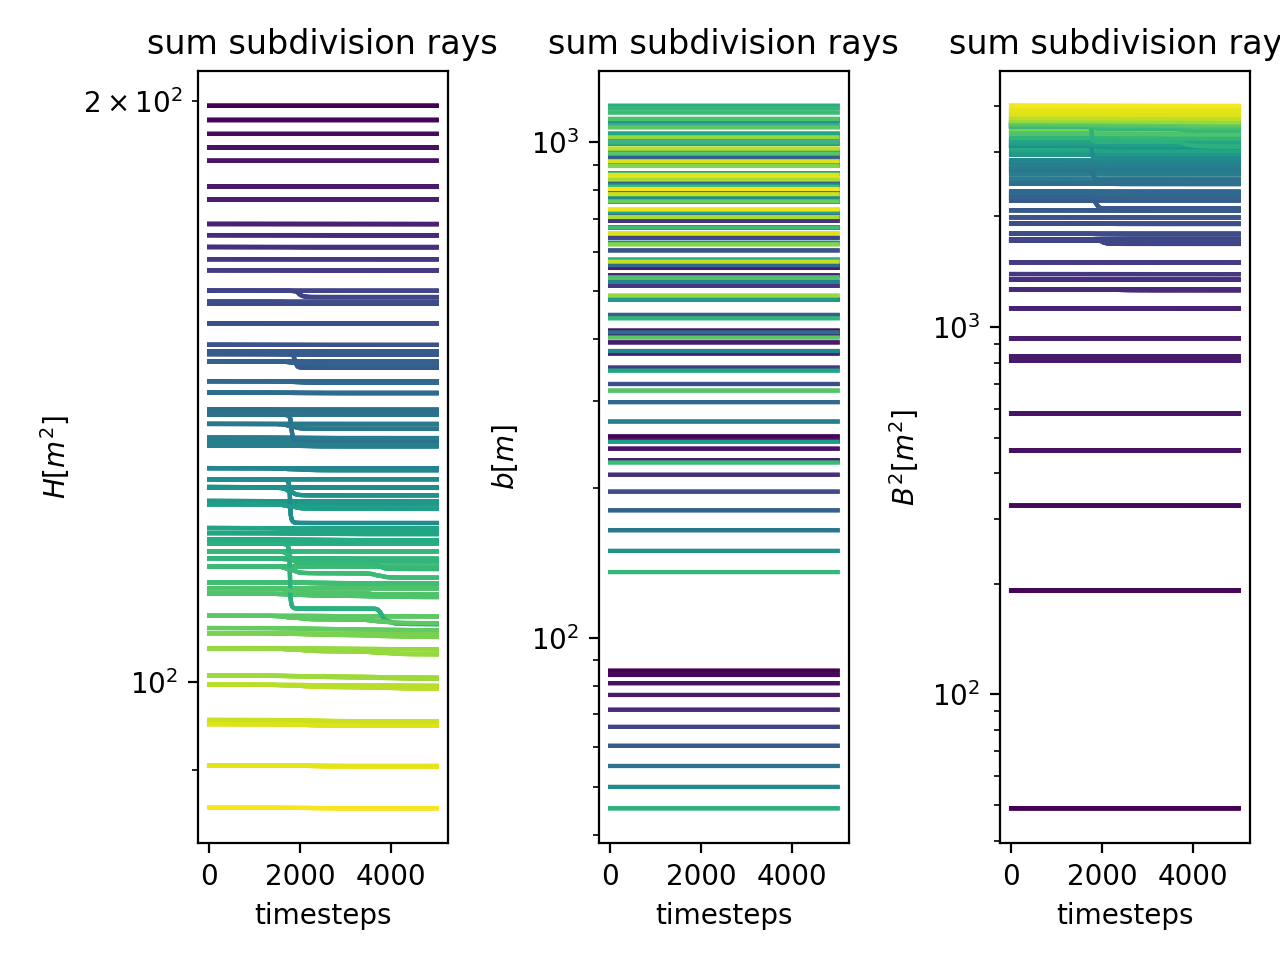

In [41]:
plot_CM(CM1, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


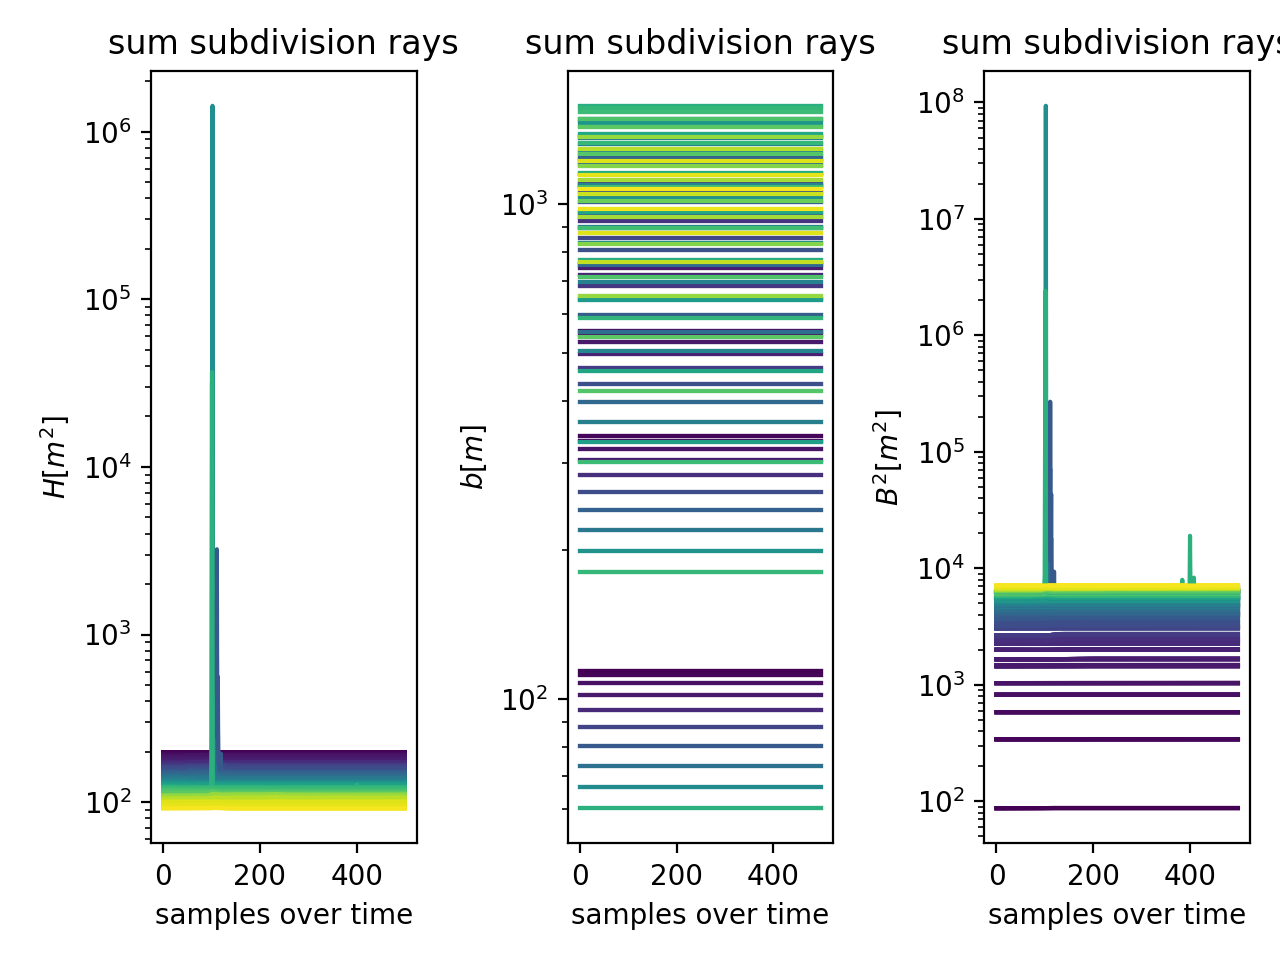

In [62]:
plot_CM(CM2, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


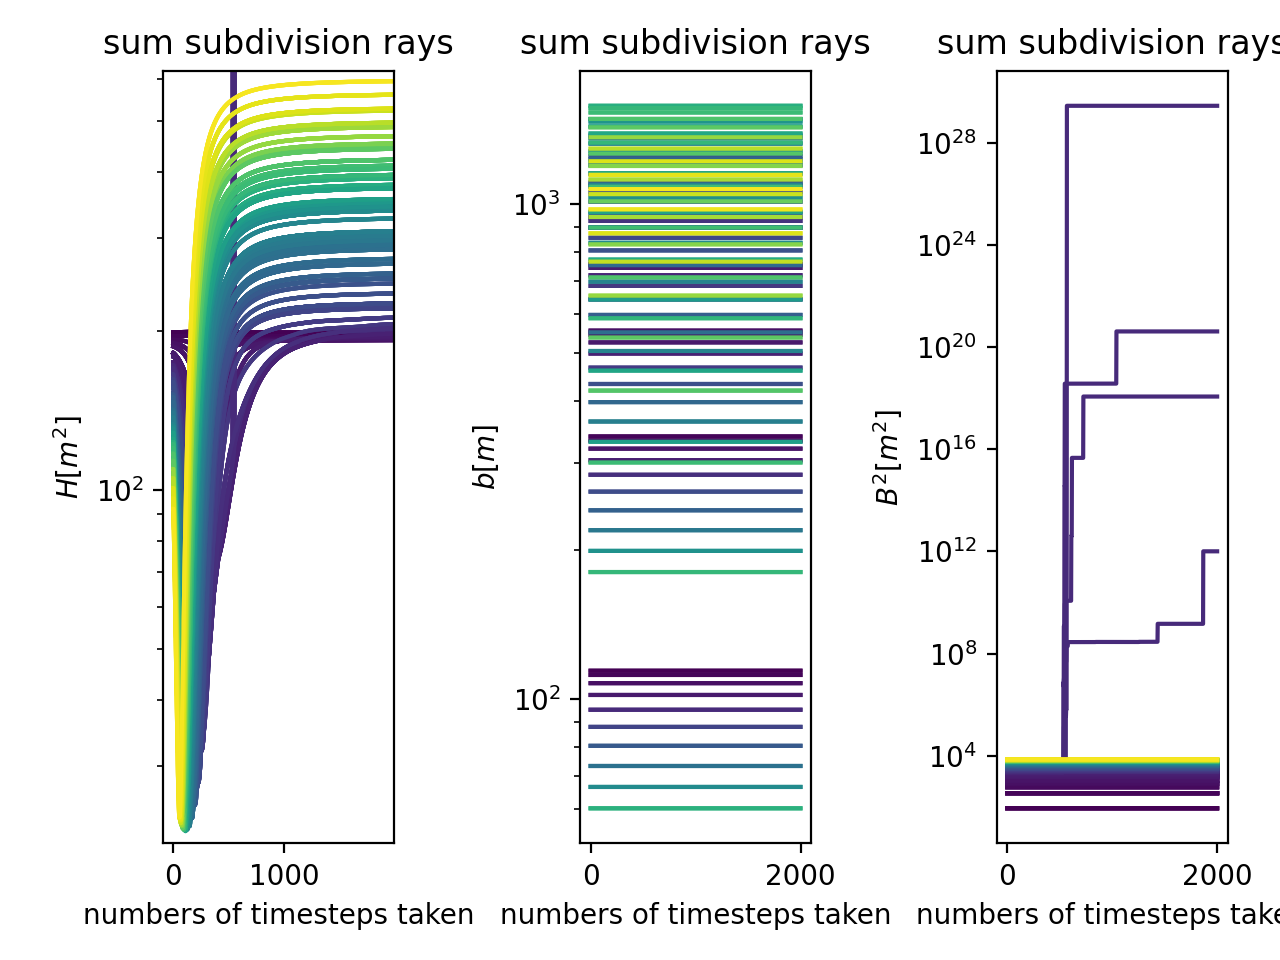

In [60]:
plot_CM(CM3, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg RK4"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


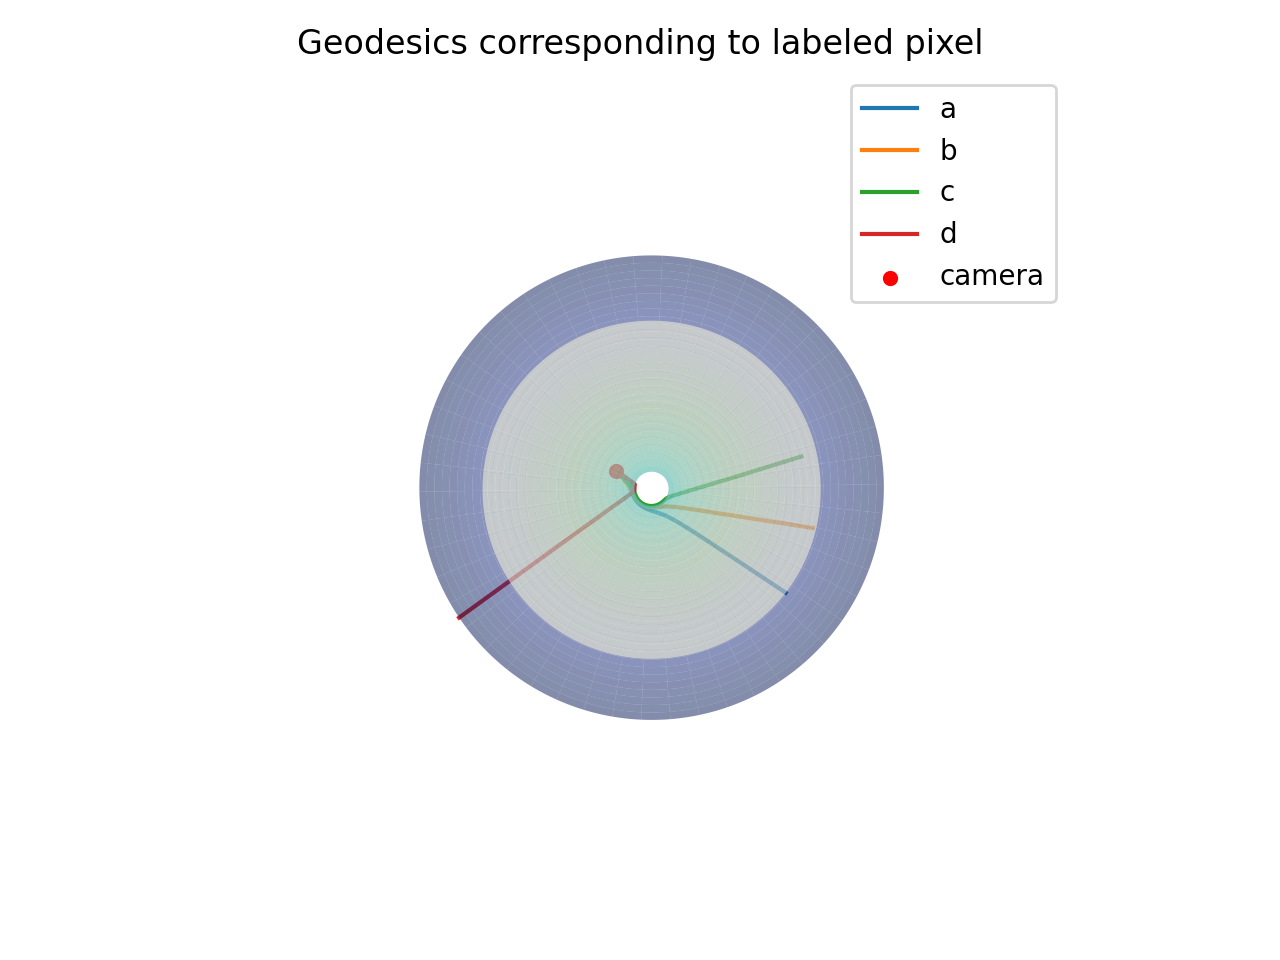

In [63]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

<IPython.core.display.Javascript object>


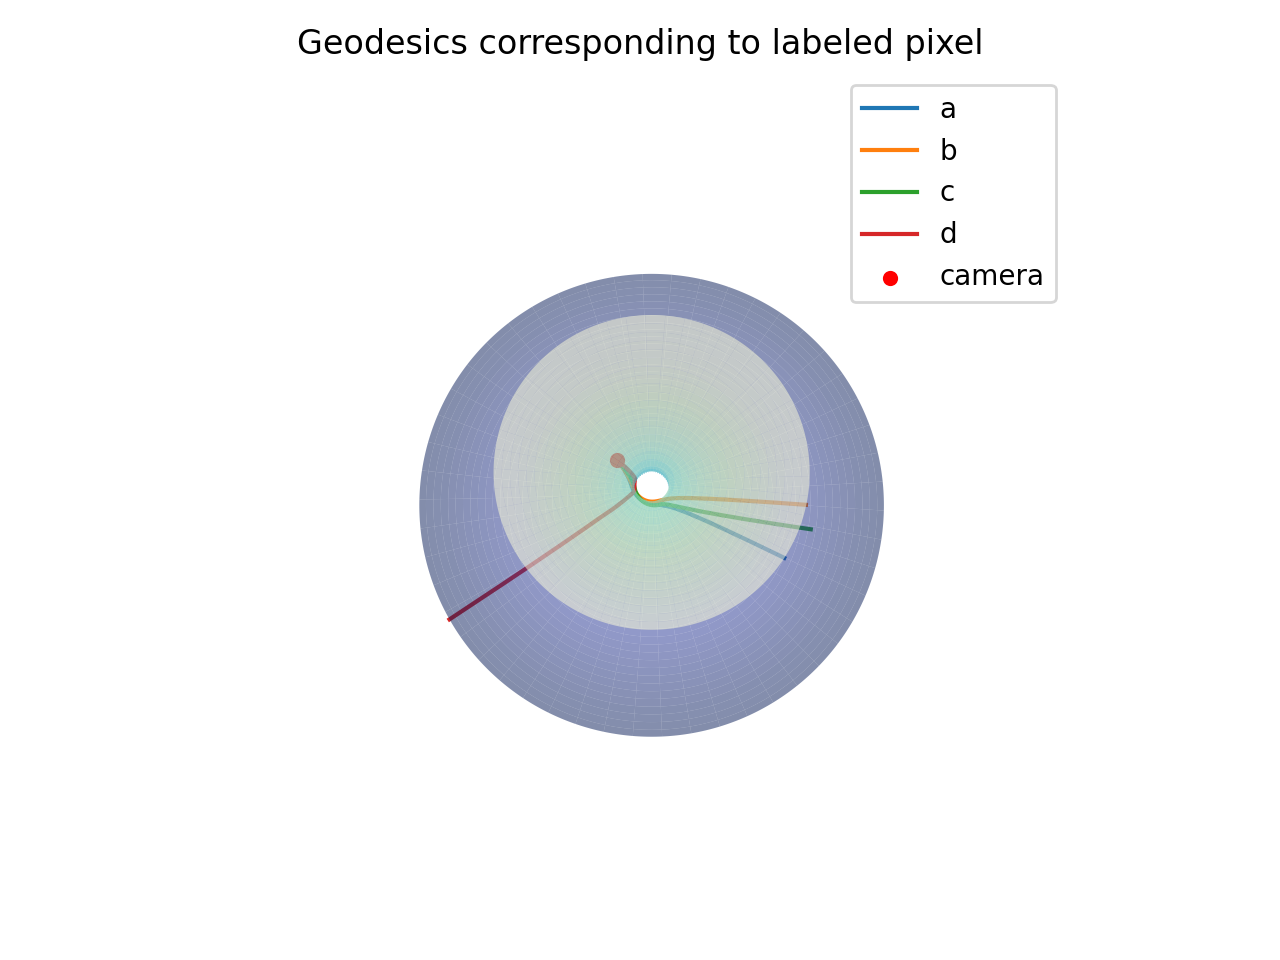

In [67]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[4,4],[36,11],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion2, Par, "Pictures/geodesics "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)